In [1]:
import numpy as np
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, Masking
from keras.layers import Activation
import matplotlib.pyplot as plt
import pickle
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.decomposition import PCA
from sklearn.metrics.cluster import contingency_matrix
from sklearn.cluster import KMeans
import matplotlib.cm as cmx
import matplotlib.colors as colors
import itertools

In [2]:
%%time
data_path = "./data/SRL_data/processed/"
data_labels = ["inputs", "ph_targets"]
dataset = {}
for dl in data_labels:
    with open(data_path+dl+'.pkl', 'rb') as fp:
        data = pickle.load(fp)
    dataset.update({dl: data})

CPU times: total: 422 ms
Wall time: 3.14 s


In [3]:
# Split dataset
train, test = int(0.7 * len(dataset['inputs'])), int(0.3 * len(dataset['inputs']))

train_data = dataset['inputs'][:train]
train_target1 = dataset["ph_targets"][:train]

test_data = dataset['inputs'][train:]
test_target1 = dataset["ph_targets"][train:]

In [4]:
np.set_printoptions(threshold=1000)

In [5]:
# Use padding, the lengths will become uniform
padded_inputs = tf.keras.utils.pad_sequences(train_data, padding="post", dtype = float, value=-412)
training_targets = [t.T for t in train_target1] # transpose the targets so we get the same shape as the input
padded_outputs = tf.keras.utils.pad_sequences(training_targets, padding ="post", dtype=float, value=-412)
padded_inputs_test = tf.keras.utils.pad_sequences(test_data, maxlen = 777, padding="post", dtype = float, value=-412)
testing_targets = [t.T for t in test_target1] # transpose the targets so we get the same shape as the input
padded_outputs_test = tf.keras.utils.pad_sequences(testing_targets, maxlen = 777, padding="post", dtype = float, value=-412)

# Original Model

In [6]:
inputs = keras.Input(shape=(padded_inputs.shape[1], padded_inputs.shape[2]))
masking = layers.Masking(mask_value=-412)(inputs)
lstmlayers, state_h, state_c = layers.LSTM(200, return_state = True, return_sequences=True, input_shape=(padded_inputs.shape[1], padded_inputs.shape[2]))(masking) 
outputs = layers.Dense(52, activation='sigmoid')(lstmlayers)

model1 = keras.Model(inputs=inputs, outputs=[outputs], name="mnist_model")
model2 = keras.Model(inputs=inputs, outputs=[outputs, state_h, state_c], name="mnist_model")

model1.compile(loss=tf.keras.losses.CategoricalCrossentropy(), optimizer='adam', metrics=['accuracy'])

model1.summary()
model2.summary()

Model: "mnist_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 777, 39)]         0         
                                                                 
 masking (Masking)           (None, 777, 39)           0         
                                                                 
 lstm (LSTM)                 [(None, 777, 200),        192000    
                              (None, 200),                       
                              (None, 200)]                       
                                                                 
 dense (Dense)               (None, 777, 52)           10452     
                                                                 
Total params: 202,452
Trainable params: 202,452
Non-trainable params: 0
_________________________________________________________________
Model: "mnist_model"
____________________________

In [7]:
%%time
history = model1.fit(padded_inputs, padded_outputs, epochs = 25, validation_split=0.33, batch_size=100, verbose=1)

CPU times: total: 0 ns
Wall time: 0 ns


In [8]:
%%time
predictedtest, state_h, state_c= model2.predict(padded_inputs_test)

CPU times: total: 0 ns
Wall time: 0 ns


# Slicing Method

In [9]:
sliced_inputs = [train_data[i][0:50] for i in range(len(train_data))]
sliced_inputs = np.asarray(sliced_inputs)
sliced_inputs_targets = [training_targets[i][0:50] for i in range(len(training_targets))]
sliced_inputs_targets = np.asarray(sliced_inputs_targets)
sliced_inputs_test = [test_data[i][0:50] for i in range(len(test_data))]
sliced_inputs_test = np.asarray(sliced_inputs_test)
sliced_inputs_targets_test = [testing_targets[i][0:50] for i in range(len(testing_targets))]
sliced_inputs_targets_test = np.asarray(sliced_inputs_targets_test)

In [51]:
inputs = keras.Input(shape=(len(sliced_inputs[0]), len(sliced_inputs[0][0])))
masking = layers.Masking(mask_value=-412)(inputs)
lstmlayers, state_h, state_c = layers.LSTM(200, return_state = True, return_sequences=True, input_shape=(len(sliced_inputs[0]), len(sliced_inputs[0][0])))(masking) 
outputs = layers.Dense(52, activation='sigmoid')(lstmlayers)

model5 = keras.Model(inputs=inputs, outputs=[outputs], name="mnist_model")
model6 = keras.Model(inputs=inputs, outputs=[outputs, state_h, state_c], name="mnist_model")

model5.compile(loss=tf.keras.losses.CategoricalCrossentropy(), optimizer='adam', metrics=['accuracy'])

model5.summary()
model6.summary()

Model: "mnist_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 50, 39)]          0         
                                                                 
 masking_3 (Masking)         (None, 50, 39)            0         
                                                                 
 lstm_3 (LSTM)               [(None, 50, 200),         192000    
                              (None, 200),                       
                              (None, 200)]                       
                                                                 
 dense_3 (Dense)             (None, 50, 52)            10452     
                                                                 
Total params: 202,452
Trainable params: 202,452
Non-trainable params: 0
_________________________________________________________________
Model: "mnist_model"
____________________________

In [52]:
%%time
history_sliced = model5.fit(sliced_inputs, sliced_inputs_targets, epochs = 25, validation_split=0.33, batch_size=100, verbose=1)

Epoch 1/25
30/30 [==============================] - 7s 123ms/step - loss: 2.8172 - accuracy: 0.3485 - val_loss: 2.1853 - val_accuracy: 0.4671
Epoch 2/25
30/30 [==============================] - 3s 85ms/step - loss: 1.9495 - accuracy: 0.5182 - val_loss: 1.6937 - val_accuracy: 0.5707
Epoch 3/25
30/30 [==============================] - 2s 84ms/step - loss: 1.5790 - accuracy: 0.5865 - val_loss: 1.4572 - val_accuracy: 0.6076
Epoch 4/25
30/30 [==============================] - 3s 84ms/step - loss: 1.3794 - accuracy: 0.6218 - val_loss: 1.3186 - val_accuracy: 0.6342
Epoch 5/25
30/30 [==============================] - 3s 93ms/step - loss: 1.2537 - accuracy: 0.6491 - val_loss: 1.2437 - val_accuracy: 0.6463
Epoch 6/25
30/30 [==============================] - 3s 87ms/step - loss: 1.1694 - accuracy: 0.6672 - val_loss: 1.1912 - val_accuracy: 0.6580
Epoch 7/25
30/30 [==============================] - 3s 90ms/step - loss: 1.1018 - accuracy: 0.6829 - val_loss: 1.1491 - val_accuracy: 0.6671
Epoch 8/25
3

In [53]:
%%time
predictedtest_sliced, state_h_sliced, state_c_sliced= model6.predict(sliced_inputs_test)

60/60 [==============================] - 2s 13ms/step
CPU times: total: 3.44 s
Wall time: 1.74 s


In [54]:
pca = PCA(n_components=3)
principalComponents_sliced = pca.fit_transform(state_h_sliced)
labels_target1_sliced = []
for sentence in sliced_inputs_targets_test:
    labels_target1_sliced.append(np.argmax(sentence[-1], axis=0))

In [55]:
def get_cmap(N, cmap='hsv'):
    """
    Returns a function that maps each index in 0, 1, ... N-1 to a distinct
    RGB color.
    """
    color_norm = colors.Normalize(vmin=0, vmax = N-1)
    scalar_map = cmx.ScalarMappable(norm=color_norm, cmap=cmap)

    def map_index_to_rgb_color(index):
        return scalar_map.to_rgba(index)

    return map_index_to_rgb_color

In [56]:
unique_labels = np.unique(labels_target1_sliced)
colors_map = get_cmap(N=len(unique_labels), cmap='jet')
ccs = [np.array(colors_map(i)) for i in range(len(unique_labels))]
lab_seq = np.array(list(itertools.chain(labels_target1_sliced)))

50


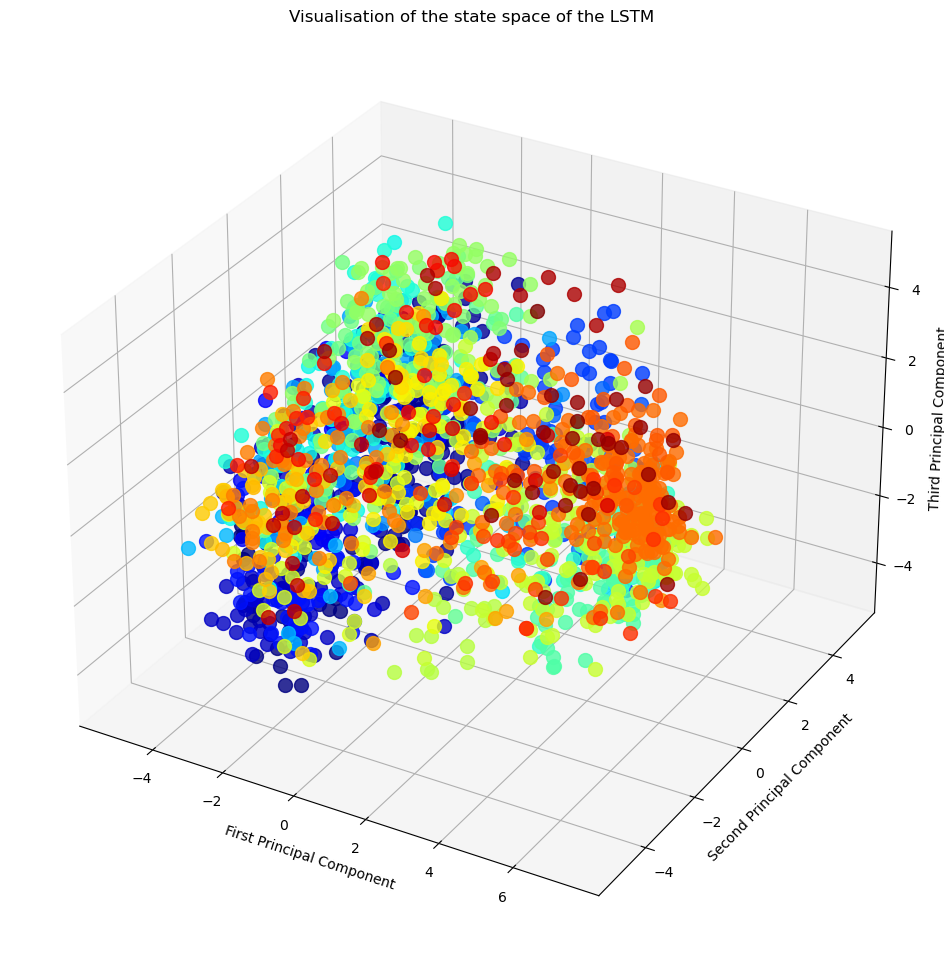

In [57]:
fig = plt.figure(figsize=[12,12])
ax = fig.add_subplot(111, projection='3d', title="Visualisation of the state space of the LSTM", xlabel= 'First Principal Component', ylabel= 'Second Principal Component', zlabel= 'Third Principal Component')
scatters = []
for color, index in zip(ccs, unique_labels):
    tmp = ax.plot(principalComponents_sliced[np.where(lab_seq == index)[0], 0], principalComponents_sliced[np.where(lab_seq == index)[0], 1],
                             principalComponents_sliced[np.where(lab_seq == index)[0], 2], marker='o', linestyle='', ms=10, c=color,
                          alpha=0.8,
                          label=index)
    scatters.append(tmp[0])

In [58]:
kmeans = KMeans(n_clusters=50, random_state=0, n_init="auto")
labels = kmeans.fit_predict(principalComponents_sliced)

In [59]:
unique_labels = np.unique(labels)
colors_map = get_cmap(N=len(unique_labels), cmap='jet')
ccs = [np.array(colors_map(i)) for i in range(len(unique_labels))]

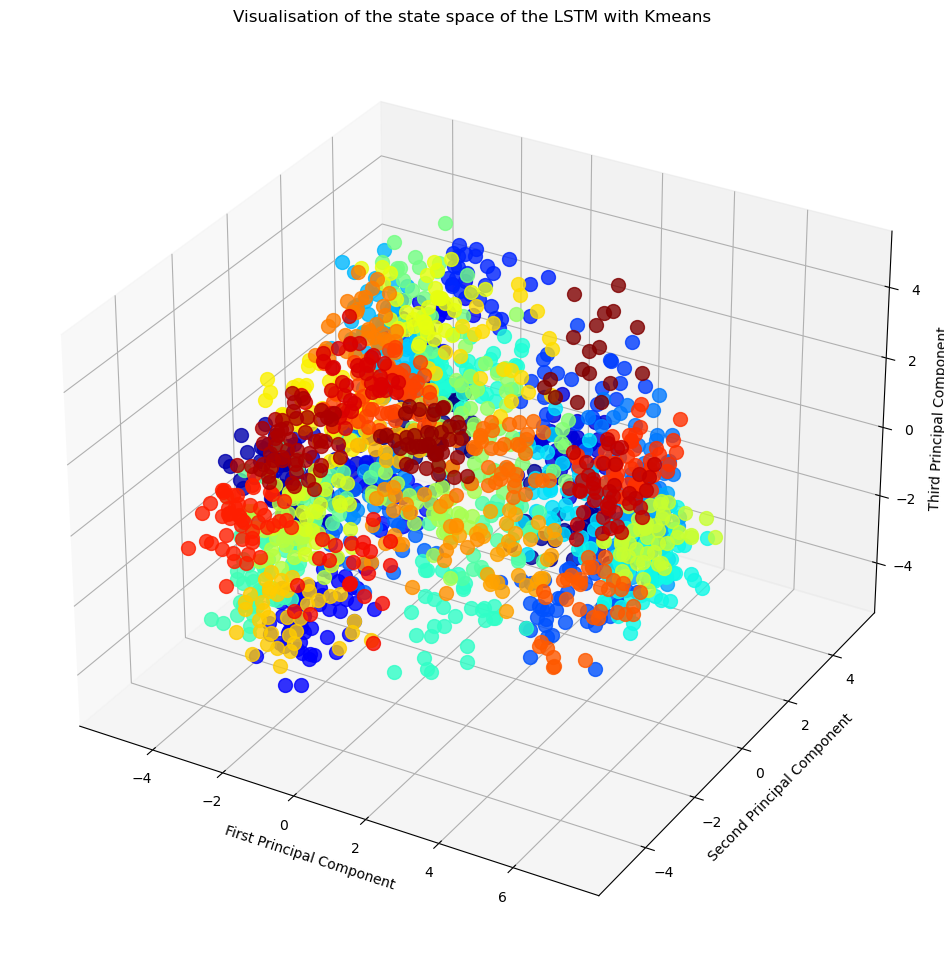

In [60]:
fig = plt.figure(figsize=[12,12])

ax = fig.add_subplot(111, projection='3d', title="Visualisation of the state space of the LSTM with Kmeans", xlabel= 'First Principal Component', ylabel= 'Second Principal Component', zlabel= 'Third Principal Component')
scatters = []
for color, index in zip(ccs, unique_labels):
    tmp = ax.plot(principalComponents_sliced[np.where(labels == index)[0], 0], principalComponents_sliced[np.where(labels == index)[0], 1],
                             principalComponents_sliced[np.where(labels == index)[0], 2], marker='o', linestyle='', ms=10, c=color,
                          alpha=0.8,
                          label=index)
    scatters.append(tmp[0])

In [61]:
mat  = contingency_matrix(lab_seq, labels)
summings = []
columnssummed = mat.sum(axis=0)
for i in mat:
    summie = 0
    for j in i:
        summie += j
    summings.append(summie)
totaldiff = 0
for i in range(50):
    totaldiff += abs(summings[i]-columnssummed[i])
print((1 - totaldiff/1760) * 100)

22.045454545454547


In [62]:
results = model5.evaluate(sliced_inputs_test, sliced_inputs_targets_test)
print("Test loss, accuracy:", results)

60/60 [==============================] - 1s 14ms/step - loss: 1.1377 - accuracy: 0.6699
Test loss, accuracy: [1.1377078294754028, 0.6699259281158447]


## PCA and Kmeans for original model

In [ ]:
pca = PCA(n_components=3)
principalComponents = pca.fit_transform(state_h)
labels_target1 = []
for sentence in padded_outputs_test:
    labels_target1.append(np.argmax(sentence[-1], axis=0))

In [ ]:
def get_cmap(N, cmap='hsv'):
    """
    Returns a function that maps each index in 0, 1, ... N-1 to a distinct
    RGB color.
    """
    color_norm = colors.Normalize(vmin=0, vmax = N-1)
    scalar_map = cmx.ScalarMappable(norm=color_norm, cmap=cmap)

    def map_index_to_rgb_color(index):
        return scalar_map.to_rgba(index)

    return map_index_to_rgb_color

In [ ]:
unique_labels = np.unique(labels_target1)
colors_map = get_cmap(N=len(unique_labels), cmap='jet')
ccs = [np.array(colors_map(i)) for i in range(len(unique_labels))]
lab_seq = np.array(list(itertools.chain(labels_target1)))

In [ ]:
fig = plt.figure(figsize=[12,12])
ax = fig.add_subplot(111, projection='3d', title="Visualisation of the state space of the LSTM", xlabel= 'First Principal Component', ylabel= 'Second Principal Component', zlabel= 'Third Principal Component')
scatters = []
for color, index in zip(ccs, unique_labels):
    tmp = ax.plot(principalComponents[np.where(lab_seq == index)[0], 0], principalComponents[np.where(lab_seq == index)[0], 1],
                             principalComponents[np.where(lab_seq == index)[0], 2], marker='o', linestyle='', ms=10, c=color,
                          alpha=0.8,
                          label=index)
    scatters.append(tmp[0])

In [ ]:
kmeans = KMeans(n_clusters=len(unique_labels), random_state=0, n_init="auto")
labels = kmeans.fit_predict(principalComponents)

In [ ]:
unique_labels = np.unique(labels)
colors_map = get_cmap(N=len(unique_labels), cmap='jet')
ccs = [np.array(colors_map(i)) for i in range(len(unique_labels))]

In [ ]:
fig = plt.figure(figsize=[12,12])
ax = fig.add_subplot(111, projection='3d', title="Visualisation of the state space of the LSTM with Kmeans", xlabel= 'First Principal Component', ylabel= 'Second Principal Component', zlabel= 'Third Principal Component')
scatters = []
for color, index in zip(ccs, unique_labels):
    tmp = ax.plot(principalComponents[np.where(labels == index)[0], 0], principalComponents[np.where(labels == index)[0], 1],
                             principalComponents[np.where(labels == index)[0], 2], marker='o', linestyle='', ms=10, c=color,
                          alpha=0.8,
                          label=index)
    scatters.append(tmp[0])

In [ ]:
mat  = contingency_matrix(lab_seq, labels)
summings = []
columnssummed = mat.sum(axis=0)
for i in mat:
    summie = 0
    for j in i:
        summie += j
    summings.append(summie)
totaldiff = 0
for i in range(23):
    totaldiff += abs(summings[i]-columnssummed[i])
print((1 - totaldiff/777) * 100)

In [ ]:
from matplotlib import pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
results = model1.evaluate(padded_inputs_test, padded_outputs_test)
print("Test loss, accuracy:", results)